# Analyzing Slack logs from NeIC channels

## TODO
- use examples from github.com/jalajthanaki/NLPython
- train sentiment analysis engine on some samples
- remove backslashes from words like it's
- upload slack logs zipfile to google drive
- count number of contributors in each channel (using <u..> string matching)

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
import os
import sys
print(sys.version)
#reload(sys)  
#sys.setdefaultencoding('utf8')
from __future__ import division

2.7.14 | packaged by conda-forge | (default, Nov  4 2017, 10:22:41) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


### Get the raw data

In [3]:
%%bash
mkdir slack_logs
cd slack_logs
mv ../NeIC_Slack_export_Dec10_2017.zip .
unzip NeIC_Slack_export_Dec10_2017.zip
cd ..

Archive:  NeIC_Slack_export_Dec10_2017.zip


mkdir: slack_logs: File exists
mv: ../NeIC_Slack_export_Dec10_2017.zip: No such file or directory
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [c]
replace random/2017-09-22.json? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(assuming [N]one)


### Inspect directory structure and file format

In [5]:
dirs = %sx ls -d slack_logs/*/
for n,i in enumerate(dirs):
    print(n,i)

(0, 'slack_logs/2nd-ndsw/')
(1, 'slack_logs/_aa/')
(2, 'slack_logs/aai/')
(3, 'slack_logs/ahm-planning/')
(4, 'slack_logs/ahm-social/')
(5, 'slack_logs/ahm/')
(6, 'slack_logs/ahm16/')
(7, 'slack_logs/ahm17/')
(8, 'slack_logs/arc-debugging/')
(9, 'slack_logs/arc-operations/')
(10, 'slack_logs/bdi/')
(11, 'slack_logs/ce-debugging/')
(12, 'slack_logs/coc/')
(13, 'slack_logs/coderefinery/')
(14, 'slack_logs/data/')
(15, 'slack_logs/dcache/')
(16, 'slack_logs/dellingr/')
(17, 'slack_logs/docker/')
(18, 'slack_logs/esm/')
(19, 'slack_logs/fgi/')
(20, 'slack_logs/fla/')
(21, 'slack_logs/general/')
(22, 'slack_logs/glenna/')
(23, 'slack_logs/hpc-core_conference_c/')
(24, 'slack_logs/kudohugbox/')
(25, 'slack_logs/loke/')
(26, 'slack_logs/metacenter/')
(27, 'slack_logs/music/')
(28, 'slack_logs/ndgf-247/')
(29, 'slack_logs/ndgf/')
(30, 'slack_logs/ndgf_groupchat_nordu_/')
(31, 'slack_logs/neic2017/')
(32, 'slack_logs/nimbus/')
(33, 'slack_logs/nlpl/')
(34, 'slack_logs/perfsonardeploy/')
(35, 's

#### Let's first explore one channel

In [22]:
dir = dirs[13] #coderefinery
os.listdir(dir)

['2016-02-22.json',
 '2016-03-08.json',
 '2016-03-09.json',
 '2016-03-10.json',
 '2016-03-11.json',
 '2016-03-18.json',
 '2016-03-31.json',
 '2016-04-03.json',
 '2016-04-04.json',
 '2016-04-12.json',
 '2016-04-14.json',
 '2016-05-01.json',
 '2016-05-02.json',
 '2016-05-11.json',
 '2016-05-17.json',
 '2016-05-20.json',
 '2016-05-22.json',
 '2016-05-23.json',
 '2016-06-13.json',
 '2016-06-14.json',
 '2016-06-20.json',
 '2016-07-07.json',
 '2016-07-08.json',
 '2016-07-29.json',
 '2016-08-16.json',
 '2016-08-17.json',
 '2016-08-22.json',
 '2016-08-29.json',
 '2016-08-30.json',
 '2016-09-02.json',
 '2016-09-06.json',
 '2016-09-07.json',
 '2016-09-12.json',
 '2016-09-13.json',
 '2016-09-14.json',
 '2016-09-22.json',
 '2016-09-27.json',
 '2016-09-28.json',
 '2016-09-29.json',
 '2016-09-30.json',
 '2016-10-03.json',
 '2016-10-04.json',
 '2016-10-05.json',
 '2016-10-06.json',
 '2016-10-07.json',
 '2016-10-08.json',
 '2016-10-09.json',
 '2016-10-10.json',
 '2016-10-11.json',
 '2016-10-12.json',


Look at the structure of the json files

In [24]:
import json

dates = os.listdir(dir)
d = dates[0] # pick the first date

# read in contents of json file
with open(dir+d,"r") as f:
    raw_json = json.loads(f.read())

# dump json
dump = json.dumps(raw_json,indent=4)
print(dump)

[
    {
        "subtype": "channel_join", 
        "type": "message", 
        "user": "U0A9NV7PX", 
        "ts": "1456141994.000002", 
        "text": "<@U0A9NV7PX> has joined the channel"
    }, 
    {
        "text": "<@U0KV7FVNV> has joined the channel", 
        "ts": "1456141994.000003", 
        "subtype": "channel_join", 
        "inviter": "U0A9NV7PX", 
        "type": "message", 
        "user": "U0KV7FVNV"
    }, 
    {
        "text": "Is the name now official? If yes, then I will set up a rudimentary website. This would help me to contact people, then I have a link to refer them to.", 
        "type": "message", 
        "user": "U0KV7FVNV", 
        "ts": "1456142521.000004"
    }
]


Aha, `subtype` only present if it's not a regular message

In [8]:
for j in raw_json:
    if "subtype" in j.keys():
        print (j["type"], j["subtype"], j["text"])
    else:
        print(j["type"], j["text"])


(u'message', u'channel_join', u'<@U0A9NV7PX> has joined the channel')
(u'message', u'channel_join', u'<@U0KV7FVNV> has joined the channel')
(u'message', u'Is the name now official? If yes, then I will set up a rudimentary website. This would help me to contact people, then I have a link to refer them to.')


### Extracting messages

We now extract all regular messages in one channel

In [29]:
dates = os.listdir(dir) # this is still the coderefinery channel
messages = []

for d in dates: 
    with open(dir+d,"r") as f:
        raw_json = json.loads(f.read())

    for j in raw_json:
        if not "subtype" in j.keys(): # exclude non-message messages
            messages.append(j["text"])


Add all words in all messages to one list

In [40]:
import re
words = []
for m in messages:
    for w in m.split(): # split up words in messages
        #w = re.sub('\s+', '', w) # remove any whitespace character [ \t\n\r\f\v]
        # keep delimiters ,.!? by using regex group, and keep multiple symbols together
#        words.append(w.lower())
#        w = re.sub(r'([,.!?]+)','',w) remove delimiters ,.!?
        words.append(w.lower())

        #w = re.split(r'([,.!?]+)', w)
#        for ww in w: # split up delimiters
#            if len(ww)>0: # get rid of empty strings
#                words.append(ww.lower())

    # add fullstop to end of messages if needed
#    if not (re.match(r"[.,!?]", m[-1])):
#        words.append(".")
    
words[-100:]

[u'to',
 u'chicago',
 u"can't",
 u'make',
 u'it',
 u'for',
 u'cyberfika',
 u'on',
 u'4.12.',
 u'<@u39tfgprd>:',
 u'just',
 u'to',
 u'confirm',
 u'again,',
 u'you',
 u'have',
 u'switched',
 u'the',
 u'days,',
 u'so',
 u'<@u2wrgc30v>',
 u'and',
 u'me',
 u'should',
 u'connect',
 u'about',
 u'now,',
 u'right?',
 u'should',
 u'be',
 u'tomorrow,',
 u"shouldn't",
 u'it?',
 u"didn't",
 u'they',
 u'switch',
 u'now,',
 u'because',
 u'of',
 u'hans,',
 u'so',
 u'he',
 u'could',
 u'be',
 u'part',
 u'of',
 u'the',
 u'strategy',
 u'day?',
 u"haven't",
 u'heard',
 u'anything.',
 u'tomorrow',
 u'is',
 u'the',
 u'correct',
 u'day',
 u'<@u06emdded>:',
 u'so',
 u'you',
 u"haven't",
 u'switched',
 u'days',
 u'after',
 u'all?',
 u'ok,',
 u'then',
 u'i',
 u"don't",
 u'log',
 u'in',
 u'now!',
 u'thanks',
 u'for',
 u'letting',
 u'me',
 u'know!',
 u'we',
 u'just',
 u'got',
 u'to',
 u'the',
 u'meeting',
 u'place.',
 u'let',
 u'me',
 u'know',
 u'if',
 u'you',
 u'change',
 u'your',
 u'minds',
 u'and',
 u'need',
 u

#### Let's do this for all the Slack channels:

In [34]:
# list with all channel names
all_channels = [d.replace("slack_logs/","").replace("/","") for d in dirs]

# dictionary with channel names as keys
words_in_channels = dict.fromkeys(all_channels)

In [41]:
# function to join messages into one long array
import re
def join_messages(messages):
    words = []
    for m in messages:
        for w in m.split(): # split up words in messages
            # not needed with python split() method...
            #w = re.sub('\s+', '', w) # remove any whitespace character [ \t\n\r\f\v]
            # keep delimiters ,.!? by using re group, and keep multiple symbols together

            # try ignoring delimiters instead:
#            w = re.split(r'([,.!?]+)', w)
#            for ww in w: # split up delimiters
#                if len(ww)>0: # get rid of empty strings
#                    words.append(ww.lower()) # make all strings lowercase
#            w = re.sub(r'([,.!?]+)','',w)
            words.append(w.lower())

        # add fullstop to end of messages if needed
#        if len(m)>0: # need to exclude empty messages
#            if not (re.match(r"[.,!?]", m[-1])):
#                words.append(".")

    return words


In [92]:
# join messages in all channels into elements of words_in_channels dict
for channel in all_channels:
    #print("channel %s"%channel)
    dates = os.listdir("slack_logs/"+channel)
    messages = []
    for d in dates: 
        with open("slack_logs/"+channel+"/"+d,"r") as f:
            raw_json = json.loads(f.read())

        for j in raw_json:
            if not "subtype" in j.keys(): # exclude non-message messages
                messages.append(j["text"])
    words_in_channels[channel] = join_messages(messages)
    print("channel {} has {} words".format(channel,len(words_in_channels[channel])))

channel 2nd-ndsw has 1644 words
channel _aa has 0 words
channel aai has 1 words
channel ahm-planning has 11713 words
channel ahm-social has 0 words
channel ahm has 5777 words
channel ahm16 has 4555 words
channel ahm17 has 38 words
channel arc-debugging has 63748 words
channel arc-operations has 1140 words
channel bdi has 867 words
channel ce-debugging has 0 words
channel coc has 257 words
channel coderefinery has 88519 words
channel data has 244 words
channel dcache has 0 words
channel dellingr has 211 words
channel docker has 15 words
channel esm has 668 words
channel fgi has 0 words
channel fla has 0 words
channel general has 54968 words
channel glenna has 3990 words
channel hpc-core_conference_c has 0 words
channel kudohugbox has 636 words
channel loke has 18 words
channel metacenter has 0 words
channel music has 2014 words
channel ndgf-247 has 2393 words
channel ndgf has 1052791 words
channel ndgf_groupchat_nordu_ has 0 words
channel neic2017 has 27186 words
channel nimbus has 0 wo

Remove empty channels

In [93]:
for i in words_in_channels.keys():
    if len(words_in_channels[i])==0:
        words_in_channels.pop(i, None)

Plot number of words in channels

(0, 200000)

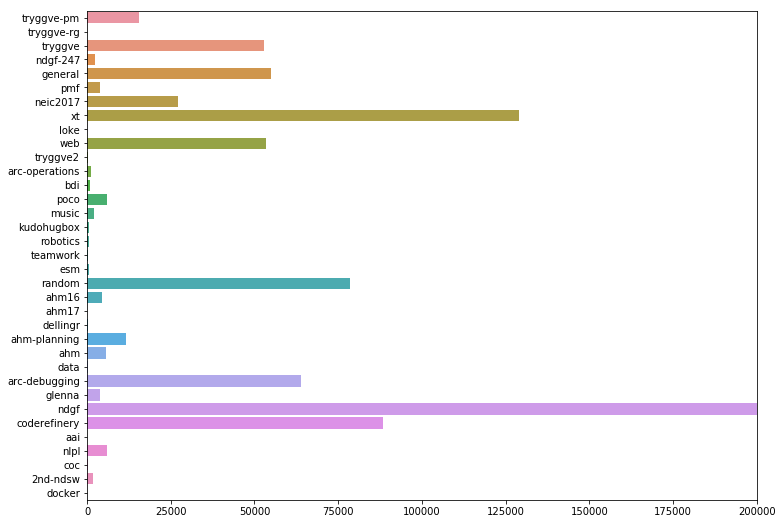

In [44]:
plt.rcParams["figure.figsize"] = [12,9]
x = words_in_channels.keys()
y = [len(words_in_channels[i]) for i in words_in_channels.keys()]
ax = sns.barplot(x=y, y=x)

ax.set_xlim([0,200000])

From now on, let's focus on the largest channels

In [94]:
channels = ["tryggve","general","xt","web","random","arc-debugging","ndgf","coderefinery"]

### Simple natural language processing

Natural language toolkit tests

In [46]:
import nltk as nltk

 > Note: lots of extra packages need to be downloaded with `nltk.download()`

Frequency distribution of words

In [47]:
#sorted(set(words))
most_common_words = dict.fromkeys(channels,0)
dists = dict.fromkeys(channels,0)
for channel in channels:
    words = words_in_channels[channel]
    dist = nltk.FreqDist(words)
    dists[channel] = dist
    most_common_words[channel] = dist.most_common(20)


We create a dataframe to work with:

In [49]:
df_words = pd.DataFrame(data=most_common_words)
df_words.head(30)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,"(the, 2819)","(the, 3451)","(the, 2034)","(the, 44223)","(the, 3120)","(the, 1993)","(the, 2276)","(the, 5209)"
1,"(to, 1514)","(to, 2920)","(to, 1626)","(to, 28047)","(to, 2051)","(to, 1596)","(to, 1729)","(to, 3752)"
2,"(is, 1325)","(i, 2542)","(i, 1244)","(i, 19936)","(a, 1851)","(i, 1288)","(i, 1292)","(i, 2869)"
3,"(i, 1247)","(and, 1717)","(a, 1014)","(is, 18188)","(i, 1615)","(you, 854)","(a, 1028)","(a, 2153)"
4,"(a, 1043)","(a, 1683)","(and, 966)","(it, 18070)","(of, 1282)","(a, 821)","(is, 808)","(and, 2065)"
5,"(it, 1012)","(we, 1496)","(is, 848)","(a, 16682)","(and, 1263)","(in, 785)","(it, 789)","(in, 2052)"
6,"(in, 936)","(is, 1430)","(in, 800)","(and, 14450)","(in, 1195)","(and, 756)","(and, 777)","(for, 1985)"
7,"(and, 902)","(it, 1340)","(of, 759)","(for, 12290)","(is, 1161)","(is, 746)","(that, 717)","(is, 1949)"
8,"(of, 766)","(for, 1213)","(it, 748)","(in, 12030)","(for, 941)","(for, 693)","(you, 688)","(you, 1626)"
9,"(that, 719)","(in, 1155)","(for, 719)","(that, 11804)","(you, 918)","(it, 624)","(for, 645)","(of, 1493)"


In [51]:
common_words = set()
for index, row in df_words.iterrows():
    for r in row:
        common_words.add(r[0])
common_words

{u'-',
 u'a',
 u'and',
 u'are',
 u'at',
 u'be',
 u'but',
 u'can',
 u'for',
 u'have',
 u'i',
 u'if',
 u'in',
 u'is',
 u'it',
 u'my',
 u'not',
 u'of',
 u'on',
 u'so',
 u'that',
 u'the',
 u'this',
 u'to',
 u'tryggve',
 u'was',
 u'we',
 u'will',
 u'with',
 u'you'}

> *Exercise: create a new dataframe with the common words as indices and number of appearances as values alon rows*

### Lexical diversity (type-token ratio)

Let's look at lexical diversity, i.e. the ratio of number of distinct words and total number of words

In [54]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [53]:
for channel in channels: # loop over the largest channels
    words = words_in_channels[channel]
    lex_div = lexical_diversity(words)
    print("Lexical diversity in %s is %f"%(channel,lex_div))
#len(set(words))/len(words)

Lexical diversity in tryggve is 0.169294
Lexical diversity in general is 0.191821
Lexical diversity in xt is 0.138659
Lexical diversity in web is 0.169905
Lexical diversity in random is 0.204878
Lexical diversity in arc-debugging is 0.150530
Lexical diversity in ndgf is 0.066855
Lexical diversity in coderefinery is 0.127306


Linguistic richness is clearly greatest in `random`, closely followed by `general`!

### Collocations, contexts and similar words

In [57]:
# this is how you can get help directly in the notebook!
nltk.word_tokenize?

In [64]:
nltk.Text?

In [88]:
nltk.Text.collocations?

**Collocations (sequences of words that co-occur more often than expected by chance)**

In [95]:
for channel in channels:
    words = words_in_channels[channel]
    all_words = " ".join(words)
    tokens = nltk.word_tokenize(all_words)
    text = nltk.Text(tokens)
    print(channel)
    print("------------")
    text.collocations()
    print("------------------------------------------------")
    print("")


tryggve
------------
tryggve hangout; live minutes; weekly meeting; use case; local ega;
meeting today; 13:00 cet; next week; tryggve weekly; feel free;
popular kudos; kudos received; sftp beamer; normal time; sensitive
data; last week; tyttebär hangout; looks like; trello cards; joakim
dillner
------------------------------------------------

general
------------
would like; good luck; n't know; internal wiki; google docs; neic
board; looks like; open source; live minutes; next week; looking
forward; 3.0 workout; pull requests; board meeting; `0` reactions;
feel free; hands meeting; take care; sensitive data; nordic software
------------------------------------------------

xt
------------
good morning; next week; stakeholder engagement; resource sharing;
missing abstract; sensitive data; feel free; looks like; google drive;
poco planning; steering group; board meeting; use cases; internal
wiki; session day; would like; sounds like; live minutes; neic 2017;
project directive
---------

**Searching for words**

What do people in different channels find boring?

In [98]:
for channel in channels:
    words = words_in_channels[channel]
    all_words = " ".join(words)
    tokens = nltk.word_tokenize(all_words)
    text = nltk.Text(tokens)
    print(channel)
    print("------------")
    text.concordance("boring")
    print("------------------------------------------------")
    print("")



tryggve
------------
Displaying 1 of 1 matches:
uess that should be more tedious or boring than web-based solution < @ u09q9fa
------------------------------------------------

general
------------
Displaying 4 of 4 matches:
policies and such , sorry for being boring : - ) i do n't know of anyone answe
ack to nordic software lab - too `` boring '' ? not scientific enough ? do you
 salsa lessons ? i find salsa a bit boring , would prefer something with a lit
the future . and life doesn ’ t get boring : tomorrow we meet with etais to di
------------------------------------------------

xt
------------
Displaying 7 of 7 matches:
s with the working group ? just the boring stuff , sorry ok , i 'll join for a
omorrow 's sessions look a bit more boring . : ) my first action this time aro
t the intoxication bonanza and into boring gate land . it was marvelous . the 
ok , if i get no more help i do the boring tweet above . or someone else , sin
 should actually focus on something boring and sch

Words that appear in similar contexts:

In [101]:
nltk.Text.similar?

In [100]:
for channel in channels:
    words = words_in_channels[channel]
    all_words = " ".join(words)
    tokens = nltk.word_tokenize(all_words)
    text = nltk.Text(tokens)
    print(channel)
    print("------------")
    text.similar("good")
    print("------------------------------------------------")
    print("")


tryggve
------------
nice up better possible hard thanks easier available ok useful able
soon yes fine interesting seems waiting easy then now
------------------------------------------------

general
------------
nice the possible long hard easy short used real bit cool great decent
cf happy similar is same new serious
------------------------------------------------

xt
------------
interesting useful great this not relevant ok that possible but okay
it ready well there to fine new better now
------------------------------------------------

web
------------
fine better ok nice okay possible that easy safe bad used over thanks
yes trying pointing trivial simple easier meant
------------------------------------------------

random
------------
bad supposed not difficult hard free it nice used possible just
planning going easy reasonable small mandatory new willing great
------------------------------------------------

arc-debugging
------------
nice updated bad have found hard used l

## "Sentiment analysis": emojis

Emojis in the Slack logs are expressed like `:slightly_smiling_face:` 

In [117]:
# join words from all channels into one list, and then join into one long "sentence"
words = [j for i in words_in_channels.values() for j in i] 
all_words = " ".join(words)

emojis = re.findall(r":[a-zA-Z_]+:",all_words) # this filters out strings like :43:

dist = nltk.FreqDist(emojis)
dist.most_common(30)


[(u':slightly_smiling_face:', 1666),
 (u':simple_smile:', 582),
 (u':wink:', 321),
 (u':smile:', 244),
 (u':disappointed:', 212),
 (u':clap:', 71),
 (u':thumbsup:', 66),
 (u':stuck_out_tongue:', 56),
 (u':grinning:', 43),
 (u':star:', 34),
 (u':champagne:', 33),
 (u':tada:', 32),
 (u':e:', 30),
 (u':blush:', 26),
 (u':confused:', 23),
 (u':mm:', 22),
 (u':beef:', 20),
 (u':beers:', 20),
 (u':fire:', 19),
 (u':sunglasses:', 19),
 (u':tyttebar:', 18),
 (u':coffee:', 17),
 (u':cc:', 17),
 (u':relieved:', 17),
 (u':newspaper:', 16),
 (u':sweat_smile:', 15),
 (u':cake:', 14),
 (u':cafe:', 14),
 (u':joy:', 13),
 (u':dc:', 12)]

Let's find the unique emojis

In [103]:
unique_emojis = set()
for i in most_common_emojis.keys():
    for j in most_common_emojis[i]:
        unique_emojis.add(j[0])
unique_emojis

{u':a:',
 u':ad:',
 u':alarm_clock:',
 u':astonished:',
 u':baby:',
 u':baca:',
 u':basketball:',
 u':bb:',
 u':bbff:',
 u':bear:',
 u':beef:',
 u':beer:',
 u':beers:',
 u':behrmann:',
 u':bike:',
 u':birthday:',
 u':black:',
 u':blush:',
 u':bouquet:',
 u':bow:',
 u':bringonline:',
 u':bulb:',
 u':cafe:',
 u':cake:',
 u':calling:',
 u':canofworms:',
 u':cc:',
 u':champagne:',
 u':clap:',
 u':cloud:',
 u':coffee:',
 u':coffin:',
 u':cold_sweat:',
 u':computer:',
 u':confused:',
 u':container_helpers:',
 u':converters:',
 u':cry:',
 u':d:',
 u':dancer:',
 u':datapointindex:',
 u':datapointloader:',
 u':datastatus:',
 u':dc:',
 u':ddff:',
 u':disappointed:',
 u':dollar:',
 u':drumroll:',
 u':dtr:',
 u':e:',
 u':earth_americas:',
 u':ef:',
 u':error:',
 u':evergreen_tree:',
 u':evil_smile:',
 u':eyes:',
 u':face_with_head_bandage:',
 u':face_with_rolling_eyes:',
 u':fb:',
 u':feba:',
 u':ff:',
 u':ffff:',
 u':fileaccess:',
 u':filecache:',
 u':fire:',
 u':flashlight:',
 u':flushed:',
 u':

Let's investigate a few key emojis

In [125]:
import emoji
common_emojis = [u":disappointed:",u":wink:",u":slightly_smiling_face:",u":simple_smile:",
              u":thumbsup:",u":clap:",u":stuck_out_tongue:",u":smile:",u":grinning:"]

for i in common_emojis:
    print(emoji.emojize('NeIC is %s'%i, use_aliases=True))
    print(i)
    print

NeIC is 😞
:disappointed:

NeIC is 😉
:wink:

NeIC is 🙂
:slightly_smiling_face:

NeIC is :simple_smile:
:simple_smile:

NeIC is 👍
:thumbsup:

NeIC is 👏
:clap:

NeIC is 😛
:stuck_out_tongue:

NeIC is 😄
:smile:

NeIC is 😀
:grinning:



hmm, `emoji` package doesn't understand `:simple_smile:`

In [129]:
channel_emojis = dict.fromkeys(channels,0)
 
for channel in channels:
    words = words_in_channels[channel]
    count = [words.count(i) for i in common_emojis]
    channel_emojis[channel] = count
#    for i in common_emojis:
#        count = words.count(i)
#        print(count)
    #    # need to join words for the FreqDist method
#    all_words = " ".join(words)

#    #emojis = re.findall(r":\w*:",all_words) # this includes strings like :43:
#    emojis = re.findall(r":[a-zA-Z_]+:",all_words) # this filters out strings like :43:
 
#    dist = nltk.FreqDist(emojis)
#    dist.most_common(20)
    
#    dists_emojis[channel] = dist
#    most_common_emojis[channel] = dist.most_common(40)
    
channel_emojis

{'arc-debugging': [11, 11, 111, 24, 0, 0, 0, 0, 0],
 'coderefinery': [4, 14, 189, 2, 1, 0, 6, 6, 1],
 'general': [4, 39, 120, 47, 2, 3, 2, 17, 4],
 'ndgf': [121, 60, 527, 321, 1, 0, 10, 38, 1],
 'random': [18, 45, 144, 36, 6, 6, 10, 37, 1],
 'tryggve': [17, 30, 118, 34, 2, 21, 6, 33, 10],
 'web': [4, 7, 98, 9, 0, 2, 6, 21, 0],
 'xt': [18, 61, 103, 66, 29, 20, 9, 44, 5]}

In [106]:
tmp = most_common_emojis.copy()
for i in most_common_emojis:
#for i in tmp:
    excluded_emojis = [x[0] for x in most_common_emojis[i] if x[0] in key_emojis]
#    excluded_emojis = [x[0] for x in tmp[i] if x[0] in key_emojis]
    l1 = [x for x in most_common_emojis[i] if x[0] in key_emojis]
    l2 = [(x,0) for x in key_emojis if x not in excluded_emojis]
    print l1
    print l2
    newlist = l1 + l2
    newlist.sort()
    most_common_emojis[i] = newlist
    #tmp[i] = newlist.sort()
most_common_emojis

[(u':slightly_smiling_face:', 118), (u':smile:', 33), (u':wink:', 31), (u':clap:', 28), (u':disappointed:', 17), (u':grinning:', 10), (u':stuck_out_tongue:', 6), (u':confused:', 5), (u':thumbsup:', 2)]
[(u':flushed:', 0), (u':heart_eyes:', 0), (u':laughing:', 0)]
[(u':slightly_smiling_face:', 197), (u':wink:', 14), (u':stuck_out_tongue:', 6), (u':smile:', 6), (u':disappointed:', 4), (u':grinning:', 3), (u':laughing:', 1), (u':flushed:', 1), (u':thumbsup:', 1)]
[(u':confused:', 0), (u':clap:', 0), (u':heart_eyes:', 0)]
[(u':slightly_smiling_face:', 528), (u':disappointed:', 122), (u':wink:', 60), (u':smile:', 38), (u':confused:', 11), (u':stuck_out_tongue:', 10)]
[(u':flushed:', 0), (u':thumbsup:', 0), (u':clap:', 0), (u':grinning:', 0), (u':heart_eyes:', 0), (u':laughing:', 0)]
[(u':slightly_smiling_face:', 103), (u':smile:', 22), (u':wink:', 7), (u':stuck_out_tongue:', 6), (u':disappointed:', 4), (u':clap:', 2)]
[(u':confused:', 0), (u':flushed:', 0), (u':thumbsup:', 0), (u':grinning:

{'arc-debugging': [(u':clap:', 0),
  (u':confused:', 1),
  (u':disappointed:', 11),
  (u':flushed:', 0),
  (u':grinning:', 0),
  (u':heart_eyes:', 0),
  (u':laughing:', 0),
  (u':slightly_smiling_face:', 112),
  (u':smile:', 0),
  (u':stuck_out_tongue:', 0),
  (u':thumbsup:', 0),
  (u':wink:', 11)],
 'coderefinery': [(u':clap:', 0),
  (u':confused:', 0),
  (u':disappointed:', 4),
  (u':flushed:', 1),
  (u':grinning:', 3),
  (u':heart_eyes:', 0),
  (u':laughing:', 1),
  (u':slightly_smiling_face:', 197),
  (u':smile:', 6),
  (u':stuck_out_tongue:', 6),
  (u':thumbsup:', 1),
  (u':wink:', 14)],
 'general': [(u':clap:', 7),
  (u':confused:', 1),
  (u':disappointed:', 4),
  (u':flushed:', 0),
  (u':grinning:', 4),
  (u':heart_eyes:', 0),
  (u':laughing:', 0),
  (u':slightly_smiling_face:', 120),
  (u':smile:', 17),
  (u':stuck_out_tongue:', 2),
  (u':thumbsup:', 4),
  (u':wink:', 40)],
 'ndgf': [(u':clap:', 0),
  (u':confused:', 11),
  (u':disappointed:', 122),
  (u':flushed:', 0),
  (u':g

In [132]:
df_emojis = pd.DataFrame(data=channel_emojis)
df_emojis.head(10)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
0,11,4,4,121,18,17,4,18
1,11,14,39,60,45,30,7,61
2,111,189,120,527,144,118,98,103
3,24,2,47,321,36,34,9,66
4,0,1,2,1,6,2,0,29
5,0,0,3,0,6,21,2,20
6,0,6,2,10,10,6,6,9
7,0,6,17,38,37,33,21,44
8,0,1,4,1,1,10,0,5


In [ ]:
#emojis, y = zip(*df_emojis.coderefinery)
#df_emojis['emojis'] = emojis
#df_emojis.set_index('emojis',drop=True, inplace=True)
#df_emojis.head(5)

Use real emojis as indices in dataframe

In [135]:
emojis=[]
for i in common_emojis:
    x = emoji.emojize(i, use_aliases=True) 
    emojis.append(x)
df_emojis["emojis"] = emojis
df_emojis.set_index('emojis',inplace=True, drop=True)
df_emojis.head(10)

,arc-debugging,coderefinery,general,ndgf,random,tryggve,web,xt
emojis,,,,,,,,
😞,11,4,4,121,18,17,4,18
😉,11,14,39,60,45,30,7,61
🙂,111,189,120,527,144,118,98,103
:simple_smile:,24,2,47,321,36,34,9,66
👍,0,1,2,1,6,2,0,29
👏,0,0,3,0,6,21,2,20
😛,0,6,2,10,10,6,6,9
😄,0,6,17,38,37,33,21,44
😀,0,1,4,1,1,10,0,5


In [138]:
df_emojis.join?

Extract only the numbers from the dataframe tuples

In [ ]:
for x in df_emojis:
    dummy, y = zip(*df_emojis[x])
    df_emojis[x] = y
df_emojis.head(5)

Normalize to total number of selected emojis in each channel

In [ ]:
df_tmp = 100*df_emojis/df_emojis.sum()
df_tmp.round(1)

### Conclusions

(virtually speaking...)
- NeIC people smile a lot overall 
- There's not a lot of clapping and thumbs-up-giving, except for `XT` people who gesticulate quite a lot with their hands
- On the other hand, `XT`-ers don't slightly as much as other channels, but they laugh quite a bit
- The most ambiguous communication takes place on `random` and `general`, as evidenced by the high proportion of winking
- `NDGF`-ers are the most disappointed channel. Anything we can do to help guys? 😉 

In [ ]:
# don't really need a heatmap plot

#emojis currently don't work as y-labels
#%matplotlib inline
##normalize:
#plt.rcParams["figure.figsize"] = [12.0, 8.0]
#plt.rcParams['figure.dpi'] = 300
#sns.set(font='Segoe UI Emoji')
#norm = 100*df_emojis / df_emojis.sum()

#g = sns.heatmap(norm,linewidths=.5,annot=True,cbar=True)
#plt.show()

### LDA 

First need some preprocessing

In [ ]:
# we'll join all words for each channel
joined_words_in_channels = dict.fromkeys(channels)
for i in channels:
    words = words_in_channels[i]
    joined_words_in_channels[i] = " ".join(words)


In [ ]:
import textmining

tdm = textmining.TermDocumentMatrix()
for channel in channels:
    tdm.add_doc(joined_words_in_channels[channel])

# write term document matrix to csv file
tdm.write_csv('matrix2.csv', cutoff=1)


In [ ]:
#for row in tdm.rows(cutoff=1):
#    print type(row)
vocab = list(tdm.rows(cutoff=1))[0]
titles = channels
X = np.array(list(tdm.rows(cutoff=1))[1:])

X.shape

In [ ]:
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

From the fit model we can look at the topic-word probabilities

In [ ]:
topic_word = model.topic_word_

for n in range(5):
    sum_pr = sum(topic_word[n,:])
    print("topic: {} sum: {}".format(n, sum_pr))

In [ ]:
n = 15
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

The other information we get from the model is document-topic probabilities

In [ ]:
doc_topic = model.doc_topic_
for n in range(8):
    topic_most_pr = doc_topic[n].argmax()
    print("doc: {} topic: {}\n{}...".format(n,topic_most_pr,titles[n][:50]))

In [ ]:
f, ax= plt.subplots(8, 1, figsize=(8, 12), sharex=True)
#for i, k in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
for i, k in enumerate([0, 1, 2, 3,4,5,6,7]):
    ax[i].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-0.5, 19.5)
    ax[i].set_xticks(range(20))
    ax[i].set_ylim(0, .5)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("{}".format(channels[k]))

ax[7].set_xlabel("Topic")

plt.tight_layout()
plt.show()

In [ ]:
#f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
#for i, k in enumerate([0, 5, 9, 14, 19]):
#    ax[i].stem(topic_word[k,:], linefmt='b-',
#               markerfmt='bo', basefmt='w-')
#    ax[i].set_xlim(-50,4350)
#    ax[i].set_ylim(0, 0.08)
#    ax[i].set_ylabel("Prob")
#    ax[i].set_title("topic {}".format(k))

#ax[4].set_xlabel("word")

#plt.tight_layout()
#plt.show()